**Environment Setup**

In [1]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
#pd.set_option('display.max_columns', None)
#np.set_printoptions(threshold=np.nan)
#np.set_printoptions(precision=3)
#sns.set(style="darkgrid")
#plt.rcParams['axes.labelsize'] = 14
#plt.rcParams['xtick.labelsize'] = 12
#plt.rcParams['ytick.labelsize'] = 12

import os
print(os.listdir('NID/NSL_KDD_dataset'))

#print("pandas : {0}".format(pd.__version__))
#print("numpy : {0}".format(np.__version__))
#print("matplotlib : {0}".format(matplotlib.__version__))
#print("seaborn : {0}".format(sns.__version__))
#print("sklearn : {0}".format(sklearn.__version__))
#print("imblearn : {0}".format(imblearn.__version__))

['KDDTest+.csv', 'KDDTest+.txt', 'KDDTrain+.csv', 'KDDTrain+.txt']


Using TensorFlow backend.


**Load NSL_KDD Data**

In [2]:
# Dataset field names
datacols = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins',
    'logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
    'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack', 'last_flag']


# Load NSL_KDD train dataset
train = pd.read_table('NID/NSL_KDD_dataset/KDDTrain+.txt', sep=',', names=datacols) # change path to where the dataset is located.
train = train.iloc[:,:-1] # removes an unwanted extra field

# Load NSL_KDD test dataset
test = pd.read_table('NID/NSL_KDD_dataset/KDDTest+.txt', sep=',', names=datacols)
test = test.iloc[:,:-1]


In [3]:
type(datacols)

list

**Train Dataset**

In [4]:
# train set dimension
#print('Train set dimension: {} rows, {} columns'.format(train.shape[0], train.shape[1]))

# View train data
train.head(3)



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune


**Test Dataset**

In [5]:
# test set dimension
#print('Test set dimension: {} rows, {} columns'.format(test.shape[0], test.shape[1]))

# View test data
test.head(3)



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal


**Data Preprocessing**

**Different Types of attacks Mapping into 4 class** 

There are different type of attacks which are mapping into 4 class :

**DoS(Denial-of-service) :** The DoS attacks are meant to force the target to stop the services that are provided by flooding it with probes illegitimate requests.

**R2L(Root to Level):** The R2L attacks are one of the most difficult to detect as they involve the network level and the host level features.

**U2R(User to Root):** The U2R attacks involve the semantic details that are very difficult to capture at an early stage. Such attacks are often content based and target an application.

**Probe:** The probe attacks are aimed at acquiring information aboutthe target network from a source that is often external to the network.

In [6]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [7]:
type(mapping)

dict

**Map attack field to attack**

NSL-KDD dataset has 42 attributes for each connection record including class label containing attack types.

In [8]:
# Apply attack class mappings to the dataset
train['attack'] = train['attack'].apply(lambda v: mapping[v])
test['attack'] = test['attack'].apply(lambda v: mapping[v])

train.head(3) # train data after mapping

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


In [9]:
# test data after mapping
test.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.0,1.0,DoS
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,DoS
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,Normal



 **Data Analysis for train and test data**

In [10]:
# Descriptive statistics

train.describe()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Descriptive statistics

test.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22544.000000,2.254400e+04,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,...,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,218.859076,1.039545e+04,2.056019e+03,0.000311,0.008428,0.000710,0.105394,0.021647,0.442202,0.119899,...,193.869411,140.750532,0.608722,0.090540,0.132261,0.019638,0.097814,0.099426,0.233385,0.226683
std,1407.176612,4.727864e+05,2.121930e+04,0.017619,0.142599,0.036473,0.928428,0.150328,0.496659,7.269597,...,94.035663,111.783972,0.435688,0.220717,0.306268,0.085394,0.273139,0.281866,0.387229,0.400875
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,121.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#print(train['num_outbound_cmds'].value_counts())
#print(test['num_outbound_cmds'].value_counts())

0    125973
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


**Counting Attacks**

In [12]:
train['attack'].value_counts()



Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: attack, dtype: int64

In [13]:
test['attack'].value_counts()

Normal    9711
DoS       7458
R2L       2754
Probe     2421
U2R        200
Name: attack, dtype: int64

In [14]:
# 'num_outbound_cmds' field has all 0 values. Hence, it will be removed from both train and test dataset since it is a redundant field.
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Attack Class Distribution
attack_class_freq_train = train[['attack']].apply(lambda x: x.value_counts())
attack_class_freq_test = test[['attack']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack,frequency_percent_train,attack,frequency_percent_test
DoS,45927,36.46,7458,33.08
Normal,67343,53.46,9711,43.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


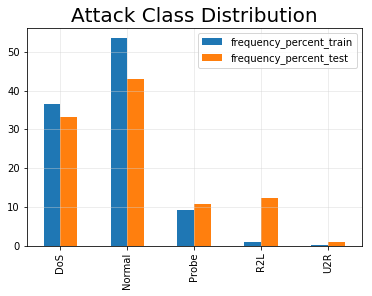

In [15]:
# Attack class bar plot
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [16]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


**Scaling Numerical Attributes**

In [17]:
#Scaling Numerical Attributes

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_train1 = pd.DataFrame(sc_train, columns = cols)
sc_test1 = pd.DataFrame(sc_test, columns = cols)



**Encoding of Categorical Attributes**

In [18]:
#Encoding of Categorical Attributes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['attack'], axis=1)
enctest = testcat.drop(['attack'], axis=1)

cat_Ytrain = traincat[['attack']].copy()
cat_Ytest = testcat[['attack']].copy()

train.head(3)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


**Data Sampling**

In [20]:
#Data Sampling
#from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# define columns and extract encoded train set for sampling 
sc_train1 = train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_train1, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass

# reshape target column to 1D array shape  
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# apply the random over-sampling
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_sample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))
train.head(3)

Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({0: 52, 1: 52, 2: 52, 3: 52, 4: 52})


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS



**Feature Selection**

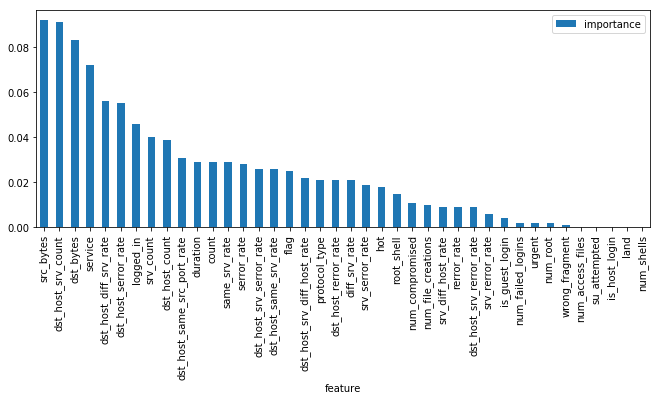

In [21]:
#Feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_res, y_res);
# extract important features
score = np.round(rfc.feature_importances_,3)
imp = pd.DataFrame({'feature':refclasscol,'importance':score})
imp = imp.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
imp.plot.bar();

In [22]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_res, y_res)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), refclasscol)]
features = [v for i, v in feature_map if i==True]

In [23]:

features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service']


**Dataset Partition**

In [24]:
# define columns to new dataframe
ncol = list(refclasscol)
ncol.append('attack')

# add a dimension to target
n_y_res = y_res[:, np.newaxis]

# create a dataframe from sampled data
res_arr = np.concatenate((X_res, n_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = ncol) 

# create test dataframe
test1 = pd.concat([sc_test1, testcat], axis=1)
test1['attack'] = test1['attack'].astype(np.float64)
test1['protocol_type'] = test1['protocol_type'].astype(np.float64)
test1['flag'] = test1['flag'].astype(np.float64)
test1['service'] =test1['service'].astype(np.float64)

res_df.shape
test1.shape


(22544, 41)

In [25]:
test1.head(3)

test1['attack'].describe()

count    22544.000000
mean         1.047507
std          1.002240
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: attack, dtype: float64

In [28]:
from collections import defaultdict
classdict = defaultdict(list)

# create two-target classes (normal class and an attack class)  
attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]

def create_classdict():
    '''This function subdivides train and test dataset into two-class attack labels''' 
    for j, k in normalclass: 
        for i, v in attacklist: 
            train1_set = res_df.loc[(res_df['attack'] == k) | (res_df['attack'] == v)]
            classdict[j +'_' + i].append(train1_set)
            # test labels
            test1_set = test1.loc[(test1['attack'] == k) | (test1['attack'] == v)]
            classdict[j +'_' + i].append(test1_set)
        
create_classdict()

In [29]:
for k, v in classdict.items(): 
    k,v
k

'Normal_U2R'

In [33]:
#pretrain = classdict['Normal_DoS'][0]
#pretest = classdict['Normal_DoS'][1]
#grpclass='Normal_DoS'

**Finalize data preprocessing for training**

In [31]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

Xresdf = classdict['Normal_DoS'][0] 
newtest = classdict['Normal_DoS'][1]
grpclass='Normal_DoS'

Xresdfnew = Xresdf[features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()

Xtest_features = newtest[features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtestcat = Xtest_features[['service']].copy()


# Fit train data
enc.fit(Xresdfcat)

# Transform train data
X_train_1hotenc = enc.transform(Xresdfcat).toarray()
       
# Transform test data
X_test_1hotenc = enc.transform(Xresdfcat).toarray()

X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xresdfnum.values, X_test_1hotenc), axis=1) 

y_train = Xresdf[['attack']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)

In [32]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train);
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier), 
#                  ('Decision Tree Classifier', DTC_Classifier), 
#                  ('KNeighborsClassifier', KNN_Classifier), 
#                  ('LogisticRegression', LGR_Classifier)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train, Y_train);


In [33]:
#
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
#models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_DoS Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9718181818181819

Model Accuracy:
 0.9711538461538461

Confusion matrix:
 [[49  3]
 [ 0 52]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        52
         1.0       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104



============================== Normal_DoS Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.8945454545454545

Model Accuracy:
 1.0

Confusion matrix:
 [[52  0]
 [ 0 52]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        52
         1.0       1.00      1.00      1.00    

In [34]:
#Test Model
for i, v in models:
    #scores = cross_val_score(v, X_test, Y_test, cv=10)
    #accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    #confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    #classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} {} Model Test Results =============================='.format
  (grpclass, i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_DoS Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.9807692307692307

Confusion matrix:
 [[50  2]
 [ 0 52]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        52
         1.0       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



============================== Normal_DoS Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9807692307692307

Confusion matrix:
 [[50  2]
 [ 0 52]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        52
         1.0       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       

In [35]:
combined_data = pd.concat([train,test])
combined_data.shape
combined_data.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


**Reduce train size for faster trainin, remove when in production**

**The following few cells are taken from the 'sample code'**

In [36]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

print(set(list(combined_data['attack']))) # use print to make it print on single line 
combined_data['attack'] = le.fit_transform(combined_data['attack'])
combined_data['protocol_type'] = le.fit_transform(combined_data['protocol_type'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['flag'] = le.fit_transform(combined_data['flag'])

print('\nDescribing attack_class: ')
combined_data['attack'].describe()

{'R2L', 'Normal', 'DoS', 'U2R', 'Probe'}

Describing attack_class: 


count    148517.000000
mean          0.790906
std           0.725785
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: attack, dtype: float64

In [44]:
# select least correlated
corr_matrix = combined_data.corr().abs().sort_values('attack_class')
# tmp.head(10) # to view CORR matrix 
leastCorrelated = corr_matrix['attack_class'].nsmallest(10)
leastCorrelated = list(leastCorrelated.index)

# select least correlated
leastSTD =  combined_data.std().to_frame().nsmallest(5, columns=0)
leastSTD = list(leastSTD.transpose().columns)  #fuckin pandas.core.indexes.base.Index   -_-
#tmp = tmp.append('num_outbound_cmds')  # might not work...
featureElimination = set(leastCorrelated + leastSTD)
len(featureElimination)
featureElimination

{'dst_bytes',
 'dst_host_rerror_rate',
 'is_host_login',
 'land',
 'num_compromised',
 'num_file_creations',
 'num_root',
 'num_shells',
 'rerror_rate',
 'root_shell',
 'src_bytes',
 'srv_rerror_rate',
 'su_attempted',
 'urgent'}

In [37]:
#combined_data=combined_data.drop(featureElimination,axis=1)
data_x = combined_data.drop('attack', axis=1)
data_y = combined_data.loc[:,['attack']]
del combined_data # free mem
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.5, random_state=42) # TODO

**Drop features with lowest STD**

In [39]:
from sklearn import linear_model

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
#from sklearn.ensemble import  KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import GaussianNB 
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import gc 
gc.collect()

411

In [41]:

#X_train.shape
#X_test.shape

(74258, 40)

**Ensembling the Result**

In [45]:
x = X_train
y = y_train['attack'].ravel()

ensem1 = DecisionTreeClassifier() 
ensem2 = RandomForestClassifier(n_estimators=25, random_state=1)
ensem3 = GradientBoostingClassifier()
ensem4 = KNeighborsClassifier()
ensem5 = GaussianNB()
ensem6 = SVC()
ET = ExtraTreesClassifier(n_estimators=15, criterion='gini', max_features='auto', bootstrap=False) # .76 # without this lil fucker, Acc: 0.75 [Ensemble], 0.78 with 

ensem = VotingClassifier(estimators=[('dt', ensem1), ('rf', ensem2), ('gnb', ensem3),('knn', ensem4),('nb', ensem5),('svm',ensem6),('et',ET)], voting='hard', n_jobs = -1) 

for clf, label in zip([ensem1, ensem2, ensem3,ensem4,ensem5,ensem6,ET, eclf], ['Decision Tree ', 'Random Forest', 'Gradient Boosting ','K-Nearest Neighbors','Naive Bayes','Support Vector Machine','ExtraTreesClassifier', 'Ensemble']): 
    tmp = clf.fit(x,y)
    pred = clf.score(X_test,y_test)
    print("Acc: %0.4f [%s]" % (pred,label))
  

Acc: 0.9930 [Decision Tree ]
Acc: 0.9952 [Random Forest]
Acc: 0.9923 [Gradient Boosting ]
Acc: 0.9843 [K-Nearest Neighbors]
Acc: 0.4255 [Naive Bayes]
Acc: 0.5195 [Support Vector Machine]
Acc: 0.9942 [ExtraTreesClassifier]
Acc: 0.9943 [Ensemble]
